# ML4SCI Task

This notebook demonstrates the model trained on data provided for **Specific Task 2: Lens Finding**


**WorkFlow**
* Load the data into the notebook with a modified structure
* Create a train folder containing both lenses and nonlenses files
* Similarly, create a test folder with the same structure
* Define Dataset class
* Define pretrained Model class which uses **Transfer Learning**
* Define train_utils class having loss, optimizer, scheduler, score function
* Define Train class having function for training, validation and training_loop
* CFG class is used to set the hyperparamters

In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
import copy
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler
import warnings
warnings.filterwarnings('ignore') 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CFG:
    lr = 1e-4
    batch_size = 32 
    num_classes = 2
    size = [224, 224]  
    nfold = 10
    custom_model = False
    model_name = "tf_efficientnet_b4_ns"  
    target_col = "target"
    epochs = 10  
    seed = 42
    transform = False
    weight_decay = 1e-5
    num_workers = 2
    train = True
    debug = False
    metric_type = "roc_auc"
    scheduler_type = "CosineLRScheduler"
    optimizer_type = "AdamW" 
    loss_type = "BCEWithLogitsLoss"
    is_cross_validate = False
    max_grad_norm = 1000
    lr_max = 2e-4
    epochs_warmup = 1.0
    pos_weight = 5
    meta_count = 3
    device = device

In [3]:
# -------------------------------
# Data Paths and Helper Function
# -------------------------------
root_dir = '/kaggle/input/deeplense/lens-finding-test'
dir_train = os.path.join(root_dir, 'train')
dir_test = os.path.join(root_dir, 'test')


path_train_lenses = os.listdir(os.path.join(dir_train, 'lenses'))
path_train_nonlenses = os.listdir(os.path.join(dir_train, 'nonlenses'))
path_test_lenses = os.listdir(os.path.join(dir_test, 'lenses'))
path_test_nonlenses = os.listdir(os.path.join(dir_test, 'nonlenses'))

print('Train lenses:', len(path_train_lenses))
print('Train nonlenses:', len(path_train_nonlenses))
print('Test lenses:', len(path_test_lenses))
print('Test nonlenses:', len(path_test_nonlenses))

Train lenses: 1730
Train nonlenses: 28675
Test lenses: 195
Test nonlenses: 19455


In [4]:
def data_helper(base_dir, d_type='train'):
    df = pd.DataFrame()
    targets = []
    data_paths = []
    if d_type == 'train':
        lenses = path_train_lenses
        nonlenses = path_train_nonlenses
        folder_lenses = 'lenses'
        folder_nonlenses = 'nonlenses'
    else:
        lenses = path_test_lenses
        nonlenses = path_test_nonlenses
        folder_lenses = 'lenses'
        folder_nonlenses = 'nonlenses'
    for fname in lenses:
        targets.append(0)
        data_paths.append(os.path.join(base_dir, folder_lenses, fname))
    for fname in nonlenses:
        targets.append(1)
        data_paths.append(os.path.join(base_dir, folder_nonlenses, fname))
    df['target'] = targets
    df['data_path'] = data_paths
    df = df.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
    return df


full_train_df = data_helper(dir_train, d_type='train')
test_df = data_helper(dir_test, d_type='test')

# -------------------------------
# Stratified Train/Validation Split
# -------------------------------
train_df, valid_df = train_test_split(
    full_train_df,
    test_size=0.1,
    stratify=full_train_df['target'],
    random_state=CFG.seed
)

In [5]:
# -------------------------------
# Augmentation Transforms
# -------------------------------
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size[0], CFG.size[1]),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            ], p=0.5),
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.5),
            ], p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    elif data == 'test':
        return A.Compose([
            A.Resize(CFG.size[0], CFG.size[1]),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

In [6]:
# -------------------------------
# PyTorch Dataset 
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_path = self.df['data_path'].iloc[idx]
        image = np.load(image_path).astype(np.float32)
        image = np.transpose(image, (1, 2, 0))  
        
        label = self.df['target'].iloc[idx]
        
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']  
        
        return image, torch.tensor(label)

In [7]:
# -------------------------------
# Model Definition
# -------------------------------
class PretrainedModel(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b4_ns', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        
        if 'efficientnet' in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(n_features, 1)
            )
            
            nn.init.xavier_normal_(self.model.classifier[1].weight)
            nn.init.constant_(self.model.classifier[1].bias, 0)
    
    def forward(self, x):
        return self.model(x) 

In [8]:
class train_utils():
    def __init__(self, CFG):
        self.CFG = CFG
    
    @property
    def get_criterion(self):
        if self.CFG.loss_type == "BCEWithLogitsLoss":
            return nn.BCEWithLogitsLoss(pos_weight=torch.tensor([self.CFG.pos_weight]).to(self.CFG.device))
        return nn.BCEWithLogitsLoss()
    
    def get_score(self, y_true, y_pred):  # Fixed: removed @property
        if self.CFG.metric_type == "accuracy_score":
            return accuracy_score(y_true, (y_pred > 0.5).astype(int))
        elif self.CFG.metric_type == "roc_auc":
            return roc_auc_score(y_true, y_pred)
    
    def get_optimizer(self, model):
        if self.CFG.optimizer_type == 'AdamW':
            return torch.optim.AdamW([
                {'params': model.model.conv_stem.parameters(), 'lr': self.CFG.lr_max/10},
                {'params': model.model.blocks.parameters()},
                {'params': model.model.classifier.parameters(), 'lr': self.CFG.lr_max*10}
            ], lr=self.CFG.lr_max, weight_decay=self.CFG.weight_decay)
        return torch.optim.Adam(model.parameters(), lr=self.CFG.lr_max)
    
    def get_scheduler(self, optimizer, num_training_steps):
        return torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.CFG.lr_max,
            epochs=self.CFG.epochs,
            steps_per_epoch=num_training_steps,
            pct_start=0.1,
            div_factor=25,
            final_div_factor=1000
        )

In [9]:
class Train():
    def __init__(self, CFG):
        self.CFG = CFG
    
    def train_fn(self, train_loader, model, criterion, optimizer, epoch, scheduler, device):
        model.train()
        running_loss = 0.0
        scaler = torch.cuda.amp.GradScaler()
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
            images = images.to(device)
            labels = labels.float().to(device).view(-1, 1) 
            
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(images)  
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.CFG.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            
            if scheduler is not None:
                scheduler.step()
                
            running_loss += loss.item()
        
        return running_loss / len(train_loader)

    def valid_fn(self, valid_loader, model, criterion, device, train_obj):
        model.eval()
        running_loss = 0.0
        y_true = []
        y_pred = []
        
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Validation"):
                images = images.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(torch.sigmoid(outputs).cpu().numpy())
        
        y_true = np.array(y_true).reshape(-1)
        y_pred = np.array(y_pred).reshape(-1)
        
        score = train_obj.get_score(y_true, y_pred)  
        return running_loss / len(valid_loader), score, y_true, y_pred
    
    def train_loop(self, train_data, valid_data):
        train_dataset = CustomDataset(train_data, transform=get_transforms(data='train'))
        valid_dataset = CustomDataset(valid_data, transform=get_transforms(data='test'))
        
        train_loader = DataLoader(train_dataset, batch_size=self.CFG.batch_size, shuffle=True, 
                                num_workers=self.CFG.num_workers, pin_memory=True)
        valid_loader = DataLoader(valid_dataset, batch_size=self.CFG.batch_size, shuffle=False, 
                                num_workers=self.CFG.num_workers, pin_memory=True)
        
        model = PretrainedModel(self.CFG.model_name, pretrained=True)
        model.to(self.CFG.device)
        
        train_obj = train_utils(self.CFG)
        optimizer = train_obj.get_optimizer(model)
        num_training_steps = len(train_loader)
        scheduler = train_obj.get_scheduler(optimizer, num_training_steps)
        criterion = train_obj.get_criterion
        
        best_score = -1
        best_model = None
        
        for epoch in range(self.CFG.epochs):
            train_loss = self.train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, self.CFG.device)
            val_loss, score, y_true, y_pred = self.valid_fn(valid_loader, model, criterion, self.CFG.device, train_obj)
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Score: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_model = copy.deepcopy(model)
                torch.save(model.state_dict(), f"./{self.CFG.model_name}_best.pth")
        
        return best_model
                

def final_evaluation(model, test_df):
    test_dataset = CustomDataset(test_df, transform=get_transforms(data='test'))
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                           num_workers=CFG.num_workers, pin_memory=True)
    
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test Evaluation"):
            images = images.to(CFG.device)
            
            # Test-time augmentation
            outputs = model(images)
            outputs_h = model(torch.flip(images, dims=[3]))
            outputs_v = model(torch.flip(images, dims=[2]))
            
            # Average predictions
            outputs = (outputs + outputs_h + outputs_v) / 3.0
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.sigmoid(outputs).cpu().numpy())
    
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    
    test_score = roc_auc_score(y_true, y_pred)
    print(f"Test Score: {test_score:.4f}")
    return y_true, y_pred, test_score

In [10]:
# -------------------------------
# Main Function
# -------------------------------
def main():
    
    if CFG.train:
        trainer = Train(CFG)
        best_model = trainer.train_loop(train_df, valid_df)
        print("\nFinal Evaluation on Test Data")
        y_true, y_pred, test_score = final_evaluation(best_model, test_df)
        
        pred_df = pd.DataFrame({
            "actual_target": y_true,
            "pred_proba": y_pred,
            "pred_target": (np.array(y_pred) > 0.5).astype(int)
        })
        return pred_df

In [11]:
torch.cuda.empty_cache()
import gc
gc.collect()

76

In [12]:
if __name__ == '__main__':
    pred_df = main()

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Validation: 100%|██████████| 96/96 [00:18<00:00,  5.14it/s]


Epoch 1: Train Loss: 0.6490 | Val Loss: 0.2619 | Score: 0.8235


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.34it/s]


Epoch 2: Train Loss: 0.2234 | Val Loss: 0.2658 | Score: 0.8587


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.42it/s]


Epoch 3: Train Loss: 0.2375 | Val Loss: 0.2770 | Score: 0.8276


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.36it/s]


Epoch 4: Train Loss: 0.2354 | Val Loss: 0.2829 | Score: 0.8197


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.38it/s]


Epoch 5: Train Loss: 0.2339 | Val Loss: 0.2851 | Score: 0.8289


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.36it/s]


Epoch 6: Train Loss: 0.2355 | Val Loss: 0.2801 | Score: 0.8358


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Epoch 7: Train Loss: 0.2394 | Val Loss: 0.2782 | Score: 0.8420


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.40it/s]


Epoch 8: Train Loss: 0.2364 | Val Loss: 0.2665 | Score: 0.8504


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.38it/s]


Epoch 9: Train Loss: 0.2354 | Val Loss: 0.2672 | Score: 0.8363


Validation: 100%|██████████| 96/96 [00:11<00:00,  8.36it/s]


Epoch 10: Train Loss: 0.2311 | Val Loss: 0.2722 | Score: 0.8523

Final Evaluation on Test Data


Test Evaluation: 100%|██████████| 615/615 [03:34<00:00,  2.86it/s]

Test Score: 0.8534


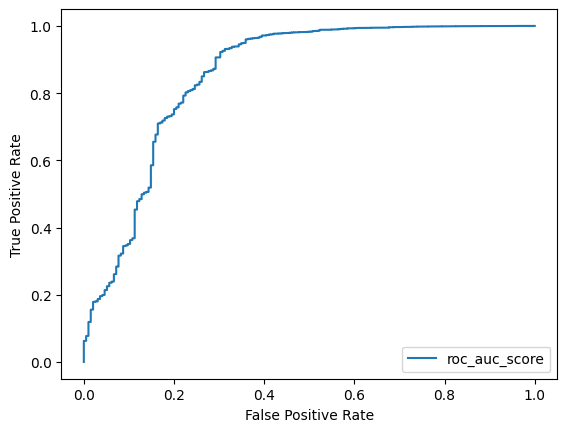

In [13]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(pred_df['actual_target'], pred_df['pred_proba'], pos_label=1)

plt.plot(fpr, tpr, label='roc_auc_score')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate') 
plt.legend(loc = 'lower right')
plt.show()

<Axes: >

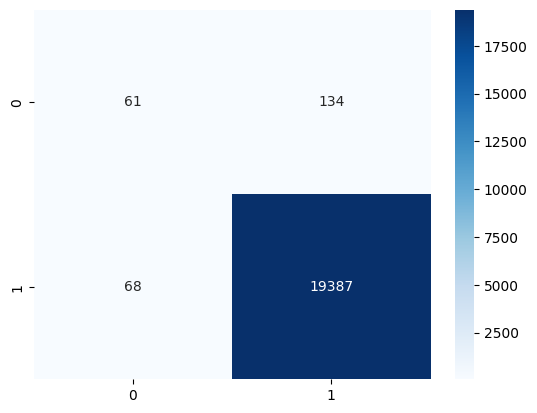

In [14]:
# Calculate confusion matrix
cm = confusion_matrix(pred_df['actual_target'], pred_df['pred_target'])
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')